# Soccer Analytics: Defensive xG (expected goals conceded) by team

## Objectives
1. **Analyze defensive xG (expected goals conceded) by team**

### Calculate xG For and Against Each Team

For each match:
- **Offensive xG**: Sum of all shot xG values for a team
- **Defensive xG**: Sum of all shot xG values for the opponent (xG conceded)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

DATA_DIR = Path("..") / "data"
POLYMARKET_DIR = DATA_DIR / "Polymarket"
STATSBOMB_DIR = DATA_DIR / "StatsBomb"


In [2]:
# StatsBomb files
sb_matches = pd.read_parquet(STATSBOMB_DIR / "matches.parquet")
sb_events = pd.read_parquet(STATSBOMB_DIR / "events.parquet")
sb_lineups = pd.read_parquet(STATSBOMB_DIR / "lineups.parquet")

print("StatsBomb Data Loaded:")
print(f"  Matches: {len(sb_matches):,} rows")
print(f"  Events: {len(sb_events):,} rows")
print(f"  Lineups: {len(sb_lineups):,} rows")

StatsBomb Data Loaded:
  Matches: 3,464 rows
  Events: 12,188,949 rows
  Lineups: 165,820 rows


In [3]:
# Filter events to only shots with xG data
shots = sb_events[
    (sb_events['type'] == 'Shot') & 
    (sb_events['shot_statsbomb_xg'].notna())
].copy()

print(f"Total shots with xG data: {len(shots):,}")
print(f"\nxG Statistics:")
print(shots['shot_statsbomb_xg'].describe())

Total shots with xG data: 88,023

xG Statistics:
count    88023.000000
mean         0.106599
std          0.149922
min          0.000180
25%          0.027747
50%          0.054884
75%          0.110167
max          0.995122
Name: shot_statsbomb_xg, dtype: float64


In [4]:
# Calculate xG per team per match
match_xg = shots.groupby(['match_id', 'team']).agg({
    'shot_statsbomb_xg': 'sum'
}).reset_index()

match_xg.columns = ['match_id', 'team', 'xG']

print("Sample match xG:")
match_xg.head(10)

Sample match xG:


,match_id,team,xG
0,7298,Chelsea FCW,2.972968
1,7298,Manchester City WFC,1.107514
2,7430,North Carolina Courage,2.152028
3,7430,Washington Spirit,0.948216
4,7443,OL Reign,1.857566
5,7443,Portland Thorns,3.867489
6,7444,Chicago Red Stars,0.580654
7,7444,North Carolina Courage,3.300426
8,7445,Utah Royals,0.747666
9,7445,Washington Spirit,1.643781


### Join with Match Metadata to Get Offensive and Defensive xG

In [5]:
# For each match, we need both teams' xG
# Create separate dataframes for home and away
home_xg = match_xg.merge(
    sb_matches[['match_id', 'home_team', 'away_team', 'match_date', 'competition_name']],
    on='match_id'
)
home_xg = home_xg[home_xg['team'] == home_xg['home_team']]
home_xg = home_xg.rename(columns={'xG': 'home_xG'})

away_xg = match_xg.merge(
    sb_matches[['match_id', 'home_team', 'away_team']],
    on='match_id'
)
away_xg = away_xg[away_xg['team'] == away_xg['away_team']]
away_xg = away_xg.rename(columns={'xG': 'away_xG'})

# Combine
match_xg_full = home_xg[['match_id', 'home_team', 'away_team', 'match_date', 'competition_name', 'home_xG']].merge(
    away_xg[['match_id', 'away_xG']],
    on='match_id',
    how='outer'
)

# Fill NaN with 0 (no shots = 0 xG)
match_xg_full['home_xG'] = match_xg_full['home_xG'].fillna(0)
match_xg_full['away_xG'] = match_xg_full['away_xG'].fillna(0)

print("Match-level xG (offensive for each team):")
match_xg_full.head(10)

Match-level xG (offensive for each team):


,match_id,home_team,away_team,match_date,competition_name,home_xG,away_xG
0,7298,Manchester City WFC,Chelsea FCW,2018-02-24,FA Women's Super League,1.107514,2.972968
1,7430,Washington Spirit,North Carolina Courage,2018-04-15,NWSL,0.948216,2.152028
2,7443,Portland Thorns,OL Reign,2018-05-05,NWSL,3.867489,1.857566
3,7444,North Carolina Courage,Chicago Red Stars,2018-05-06,NWSL,3.300426,0.580654
4,7445,Utah Royals,Washington Spirit,2018-05-06,NWSL,0.747666,1.643781
5,7451,North Carolina Courage,Washington Spirit,2018-05-13,NWSL,1.867851,1.185288
6,7456,NJ/NY Gotham FC,North Carolina Courage,2018-05-20,NWSL,1.835904,3.184335
7,7457,Orlando Pride,North Carolina Courage,2018-05-24,NWSL,1.713852,4.390527
8,7471,Orlando Pride,North Carolina Courage,2018-06-30,NWSL,0.982378,1.370617
9,7472,OL Reign,Portland Thorns,2018-07-01,NWSL,1.747613,1.293514


### Create Team-Level Dataset with Offensive and Defensive xG

In [6]:
# Create records for home team
home_records = match_xg_full[['match_id', 'match_date', 'competition_name', 'home_team', 'away_team', 'home_xG', 'away_xG']].copy()
home_records.columns = ['match_id', 'match_date', 'competition_name', 'team', 'opponent', 'xG_for', 'xG_against']
home_records['location'] = 'Home'

# Create records for away team
away_records = match_xg_full[['match_id', 'match_date', 'competition_name', 'away_team', 'home_team', 'away_xG', 'home_xG']].copy()
away_records.columns = ['match_id', 'match_date', 'competition_name', 'team', 'opponent', 'xG_for', 'xG_against']
away_records['location'] = 'Away'

# Combine
team_match_xg = pd.concat([home_records, away_records], ignore_index=True)

print(f"\nTotal team-match records: {len(team_match_xg):,}")
print("\nSample records:")
team_match_xg.head(10)


Total team-match records: 6,928

Sample records:


,match_id,match_date,competition_name,team,opponent,xG_for,xG_against,location
0,7298,2018-02-24,FA Women's Super League,Manchester City WFC,Chelsea FCW,1.107514,2.972968,Home
1,7430,2018-04-15,NWSL,Washington Spirit,North Carolina Courage,0.948216,2.152028,Home
2,7443,2018-05-05,NWSL,Portland Thorns,OL Reign,3.867489,1.857566,Home
3,7444,2018-05-06,NWSL,North Carolina Courage,Chicago Red Stars,3.300426,0.580654,Home
4,7445,2018-05-06,NWSL,Utah Royals,Washington Spirit,0.747666,1.643781,Home
5,7451,2018-05-13,NWSL,North Carolina Courage,Washington Spirit,1.867851,1.185288,Home
6,7456,2018-05-20,NWSL,NJ/NY Gotham FC,North Carolina Courage,1.835904,3.184335,Home
7,7457,2018-05-24,NWSL,Orlando Pride,North Carolina Courage,1.713852,4.390527,Home
8,7471,2018-06-30,NWSL,Orlando Pride,North Carolina Courage,0.982378,1.370617,Home
9,7472,2018-07-01,NWSL,OL Reign,Portland Thorns,1.747613,1.293514,Home


### Aggregate Defensive xG by Team

In [7]:
# Calculate team statistics
team_defensive_stats = team_match_xg.groupby('team').agg({
    'match_id': 'count',
    'xG_for': 'sum',
    'xG_against': 'sum'  # This is defensive xG!
}).reset_index()

team_defensive_stats.columns = ['team', 'matches_played', 'total_xG_for', 'total_xG_against']

# Calculate per-match averages
team_defensive_stats['avg_xG_for_per_match'] = team_defensive_stats['total_xG_for'] / team_defensive_stats['matches_played']
team_defensive_stats['avg_xG_against_per_match'] = team_defensive_stats['total_xG_against'] / team_defensive_stats['matches_played']

# Calculate net xG (offensive - defensive)
team_defensive_stats['net_xG_per_match'] = team_defensive_stats['avg_xG_for_per_match'] - team_defensive_stats['avg_xG_against_per_match']

# Sort by best defensive record (lowest xG against)
team_defensive_stats = team_defensive_stats.sort_values('avg_xG_against_per_match')

print("\n=== BEST DEFENSIVE TEAMS (Lowest xG Conceded Per Match) ===")
print(team_defensive_stats.head(20).to_string(index=False))


=== BEST DEFENSIVE TEAMS (Lowest xG Conceded Per Match) ===
               team  matches_played  total_xG_for  total_xG_against  avg_xG_for_per_match  avg_xG_against_per_match  net_xG_per_match
      Argentina U20               1      1.726488          0.446860              1.726488                  0.446860          1.279627
        Chelsea FCW              57    143.258179         37.175602              2.513301                  0.652204          1.861098
               Ajax               3      6.156651          1.966975              2.052217                  0.655658          1.396559
       Nashville SC               1      0.550400          0.666627              0.550400                  0.666627         -0.116227
           FC Porto               1      0.499920          0.682694              0.499920                  0.682694         -0.182774
        Arsenal WFC              57    132.706146         41.539841              2.328178                  0.728769          1.599409
 

### Visualize Defensive Performance

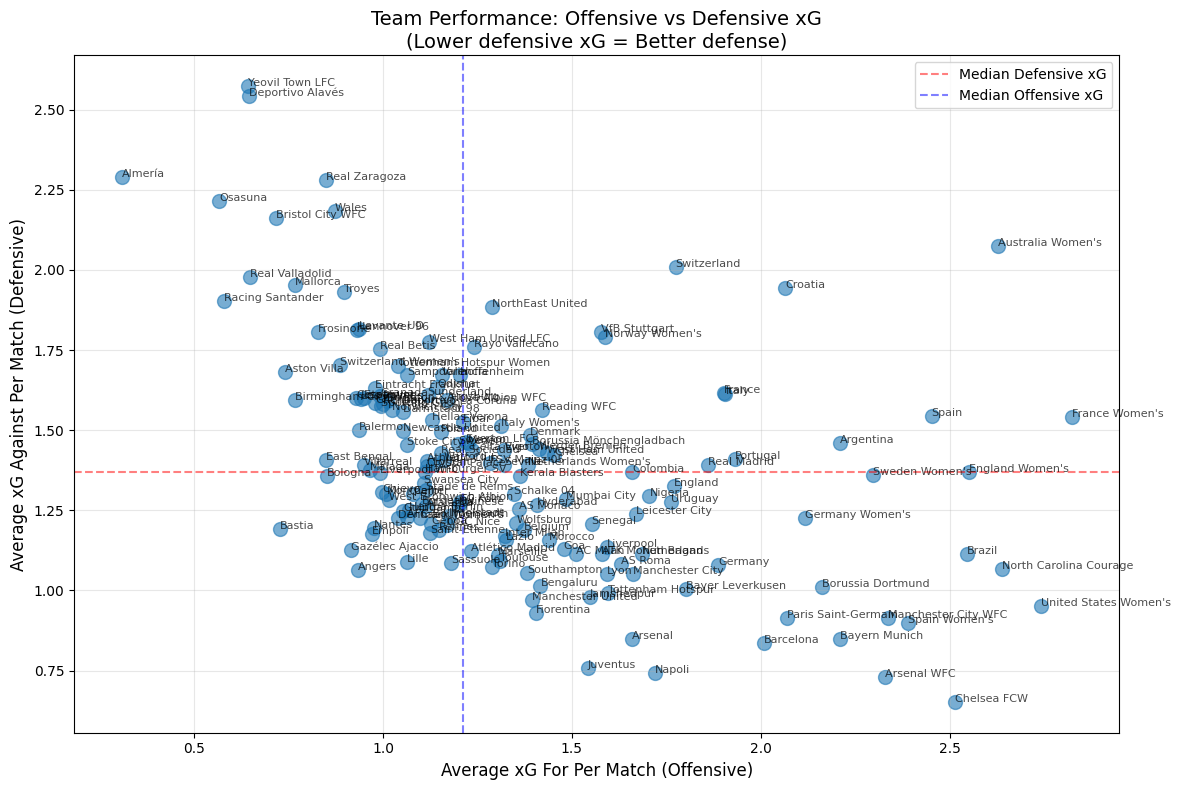

In [8]:
# Filter to teams with at least 10 matches for meaningful stats
teams_min_matches = team_defensive_stats[team_defensive_stats['matches_played'] >= 10].copy()

# Plot: Offensive vs Defensive xG
plt.figure(figsize=(12, 8))
plt.scatter(
    teams_min_matches['avg_xG_for_per_match'],
    teams_min_matches['avg_xG_against_per_match'],
    s=100,
    alpha=0.6
)

# Add team labels for top teams
for idx, row in teams_min_matches.iterrows():
    plt.annotate(
        row['team'],
        (row['avg_xG_for_per_match'], row['avg_xG_against_per_match']),
        fontsize=8,
        alpha=0.7
    )

# Add reference lines
plt.axhline(teams_min_matches['avg_xG_against_per_match'].median(), color='red', linestyle='--', alpha=0.5, label='Median Defensive xG')
plt.axvline(teams_min_matches['avg_xG_for_per_match'].median(), color='blue', linestyle='--', alpha=0.5, label='Median Offensive xG')

plt.xlabel('Average xG For Per Match (Offensive)', fontsize=12)
plt.ylabel('Average xG Against Per Match (Defensive)', fontsize=12)
plt.title('Team Performance: Offensive vs Defensive xG\n(Lower defensive xG = Better defense)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('offensive_vs_defensive_xg.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\nChart saved as 'offensive_vs_defensive_xg.png'")

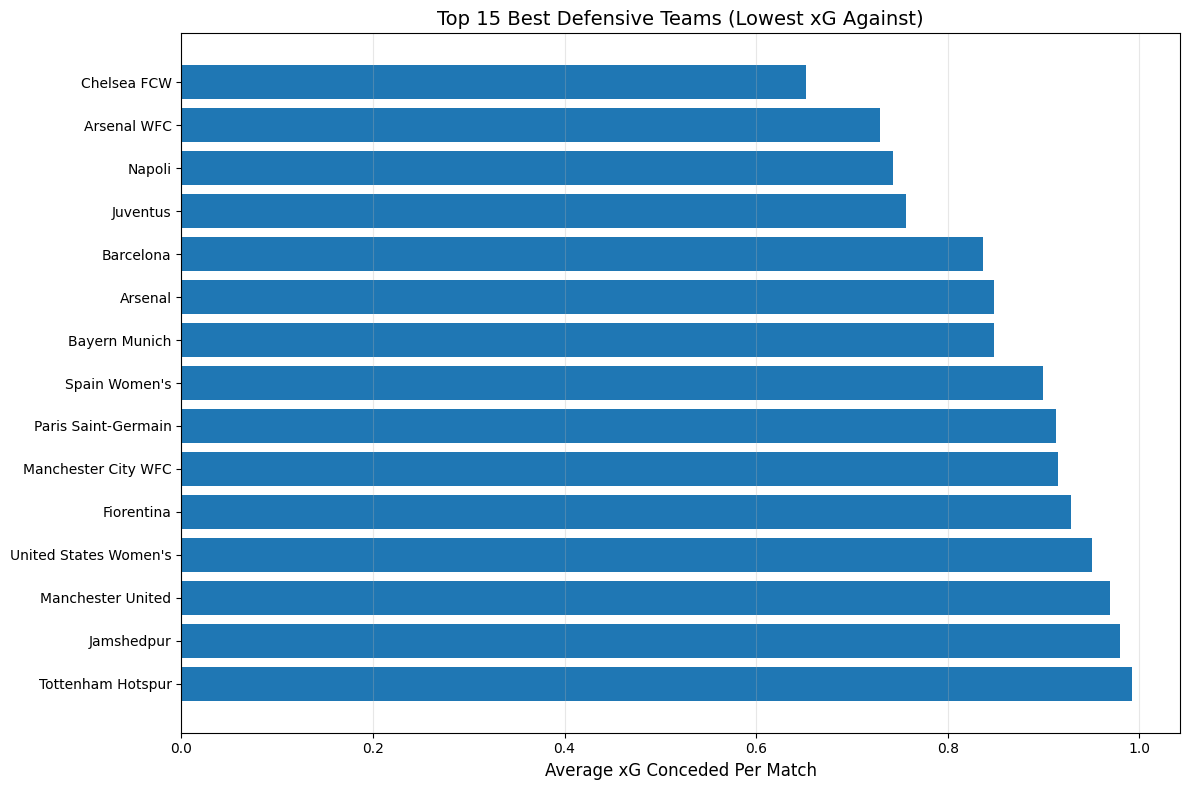

In [9]:
# Bar chart: Top 15 Best Defenses
top_defenses = teams_min_matches.nsmallest(15, 'avg_xG_against_per_match')

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_defenses)), top_defenses['avg_xG_against_per_match'])
plt.yticks(range(len(top_defenses)), top_defenses['team'])
plt.xlabel('Average xG Conceded Per Match', fontsize=12)
plt.title('Top 15 Best Defensive Teams (Lowest xG Against)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
# plt.savefig('top_defenses.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\nChart saved as 'top_defenses.png'")

### Advanced Analysis - Specific Team Deep Dive

Let's analyze Arsenal as an example.

In [10]:
# Select team to analyze
TEAM_TO_ANALYZE = 'Arsenal'

arsenal_data = team_match_xg[team_match_xg['team'] == TEAM_TO_ANALYZE].copy()
arsenal_data = arsenal_data.sort_values('match_date')

print(f"\n=== {TEAM_TO_ANALYZE} Analysis ===")
print(f"Total matches: {len(arsenal_data)}")
print(f"Average xG For: {arsenal_data['xG_for'].mean():.2f}")
print(f"Average xG Against: {arsenal_data['xG_against'].mean():.2f}")
print(f"Net xG per match: {(arsenal_data['xG_for'].mean() - arsenal_data['xG_against'].mean()):.2f}")

print("\nRecent matches:")
arsenal_data[['match_date', 'opponent', 'location', 'xG_for', 'xG_against']].tail(10)


=== Arsenal Analysis ===
Total matches: 76
Average xG For: 1.66
Average xG Against: 0.85
Net xG per match: 0.81

Recent matches:


,match_date,opponent,location,xG_for,xG_against
4702,2016-03-05,Tottenham Hotspur,Away,0.732763,1.248720
4364,2016-03-19,Everton,Away,1.830370,0.458831
1038,2016-04-02,Watford,Home,2.576715,0.432057
4625,2016-04-09,West Ham United,Away,1.843034,1.257756
929,2016-04-17,Crystal Palace,Home,1.736554,0.387562
1204,2016-04-21,West Bromwich Albion,Home,1.318571,0.734106
4374,2016-04-24,Sunderland,Away,1.338112,0.501765
1104,2016-04-30,Norwich City,Home,0.814684,0.815282
4698,2016-05-08,Manchester City,Away,0.887442,0.738292
961,2016-05-15,Aston Villa,Home,2.922745,0.301122


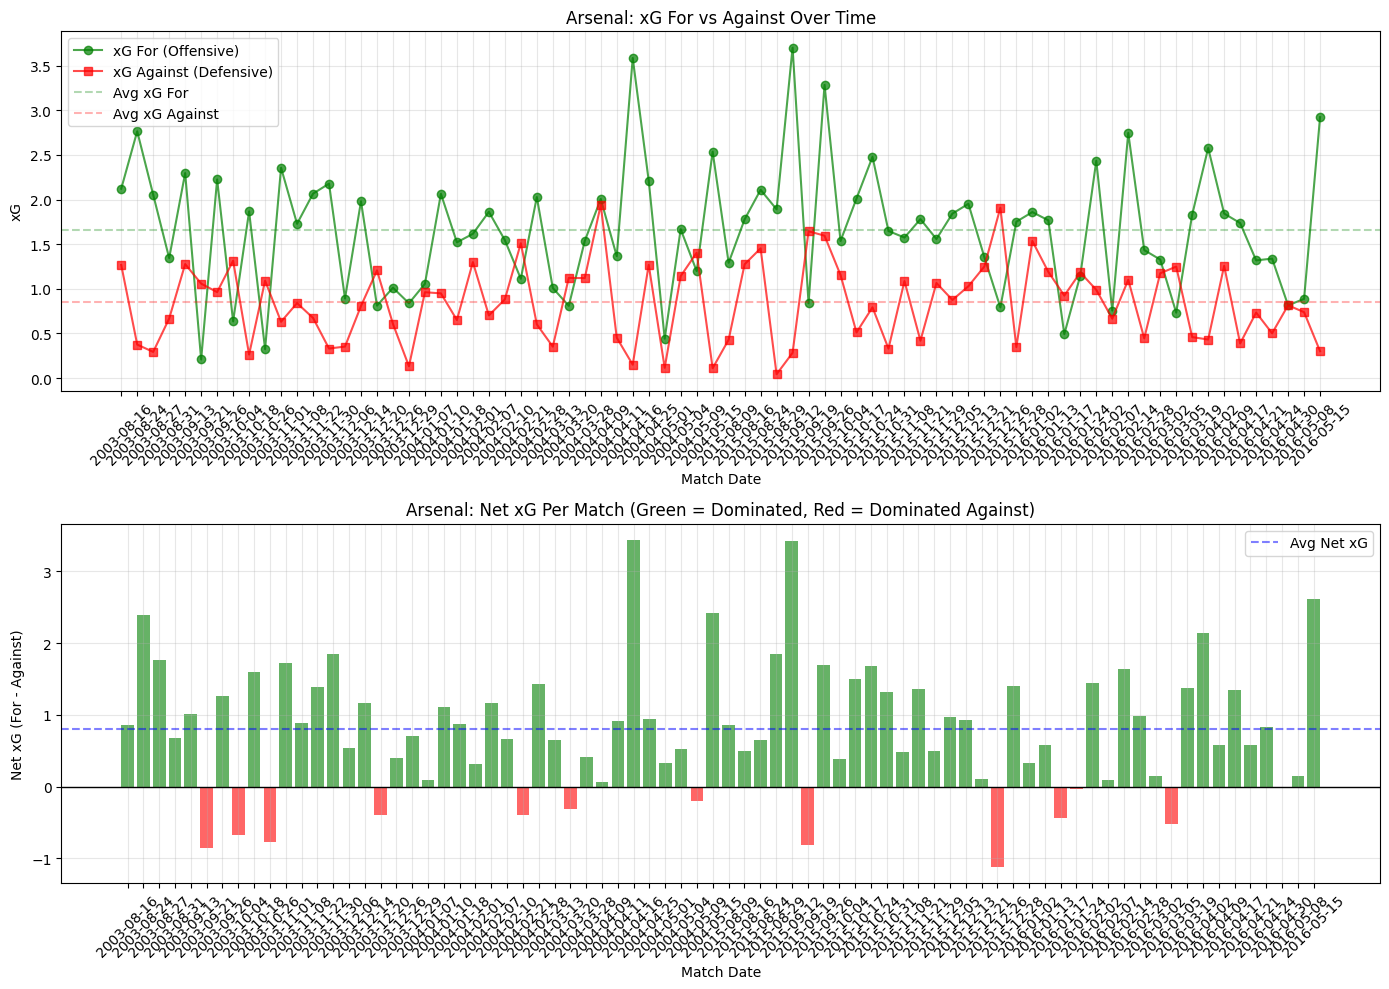

In [11]:
# Plot Arsenal's xG trend over time
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: xG For and Against over time
ax[0].plot(arsenal_data['match_date'], arsenal_data['xG_for'], marker='o', label='xG For (Offensive)', color='green', alpha=0.7)
ax[0].plot(arsenal_data['match_date'], arsenal_data['xG_against'], marker='s', label='xG Against (Defensive)', color='red', alpha=0.7)
ax[0].axhline(arsenal_data['xG_for'].mean(), color='green', linestyle='--', alpha=0.3, label='Avg xG For')
ax[0].axhline(arsenal_data['xG_against'].mean(), color='red', linestyle='--', alpha=0.3, label='Avg xG Against')
ax[0].set_xlabel('Match Date')
ax[0].set_ylabel('xG')
ax[0].set_title(f'{TEAM_TO_ANALYZE}: xG For vs Against Over Time')
ax[0].legend()
ax[0].grid(True, alpha=0.3)
ax[0].tick_params(axis='x', rotation=45)

# Plot 2: Net xG (xG_for - xG_against)
arsenal_data['net_xG'] = arsenal_data['xG_for'] - arsenal_data['xG_against']
colors = ['green' if x > 0 else 'red' for x in arsenal_data['net_xG']]
ax[1].bar(arsenal_data['match_date'], arsenal_data['net_xG'], color=colors, alpha=0.6)
ax[1].axhline(0, color='black', linewidth=1)
ax[1].axhline(arsenal_data['net_xG'].mean(), color='blue', linestyle='--', alpha=0.5, label='Avg Net xG')
ax[1].set_xlabel('Match Date')
ax[1].set_ylabel('Net xG (For - Against)')
ax[1].set_title(f'{TEAM_TO_ANALYZE}: Net xG Per Match (Green = Dominated, Red = Dominated Against)')
ax[1].legend()
ax[1].grid(True, alpha=0.3)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
# plt.savefig(f'{TEAM_TO_ANALYZE.lower()}_xg_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# print(f"\nChart saved as '{TEAM_TO_ANALYZE.lower()}_xg_analysis.png'")

### Shot Quality Analysis - xG per Shot 

Teams with high avg xG/shot are creating higher quality chances (closer to goal, better angles). 

Low avg xG/shot suggests lots of low-quality speculative shots.

Teams by Shot Quality (avg xG per shot):
                  team   total_xG  total_shots  avg_xG_per_shot
74            Congo DR  23.923197          108         0.221511
253       South Africa  19.244862           91         0.211482
81               Cádiz   4.718754           23         0.205163
135             Huesca   3.754031           19         0.197581
55              Canada  19.450558          109         0.178445
239             Russia  14.579036           84         0.173560
24   Australia Women's  28.917898          169         0.171112
71       Clermont Foot   4.840976           29         0.166930
138           Hércules   2.134987           13         0.164230
290          Venezuela  10.061128           62         0.162276
96     England Women's  66.324379          411         0.161373
13           Argentina  48.612926          309         0.157323
268     Sweden Women's  52.848080          357         0.148034
77             Croatia  43.368370          295         0.147011

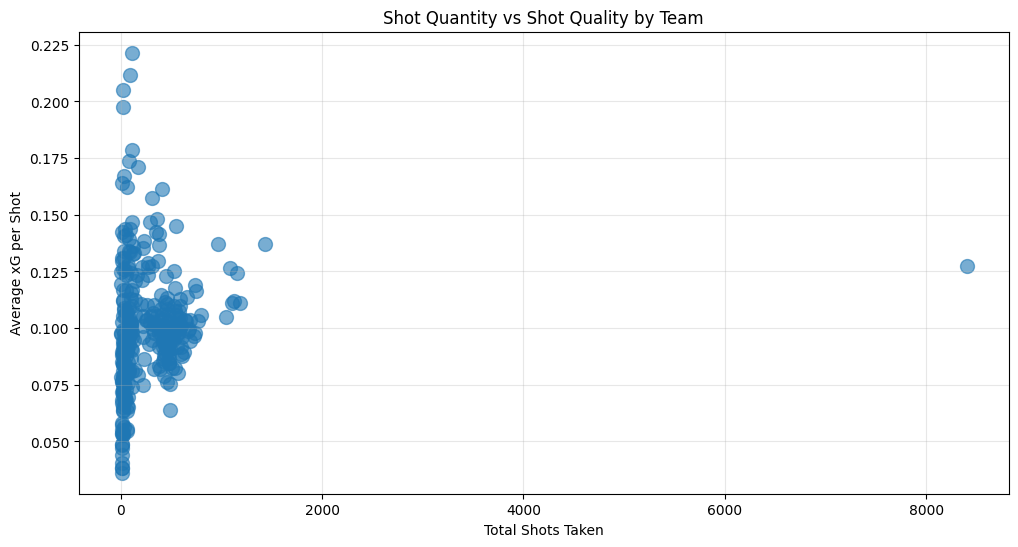

In [12]:
# Calculate average xG value per shot (higher = better shot quality)
shot_quality = sb_events[
    (sb_events['type'] == 'Shot') & 
    (sb_events['shot_statsbomb_xg'].notna())
].copy()

team_shot_quality = shot_quality.groupby('team').agg({
    'shot_statsbomb_xg': ['sum', 'count', 'mean']
}).reset_index()

team_shot_quality.columns = ['team', 'total_xG', 'total_shots', 'avg_xG_per_shot']
team_shot_quality = team_shot_quality.sort_values('avg_xG_per_shot', ascending=False)

print("Teams by Shot Quality (avg xG per shot):")
print(team_shot_quality.head(15))

# Visualize
plt.figure(figsize=(12, 6))
plt.scatter(team_shot_quality['total_shots'], 
           team_shot_quality['avg_xG_per_shot'],
           alpha=0.6, s=100)
plt.xlabel('Total Shots Taken')
plt.ylabel('Average xG per Shot')
plt.title('Shot Quantity vs Shot Quality by Team')
plt.grid(True, alpha=0.3)
plt.show()

Shot Location Heatmap

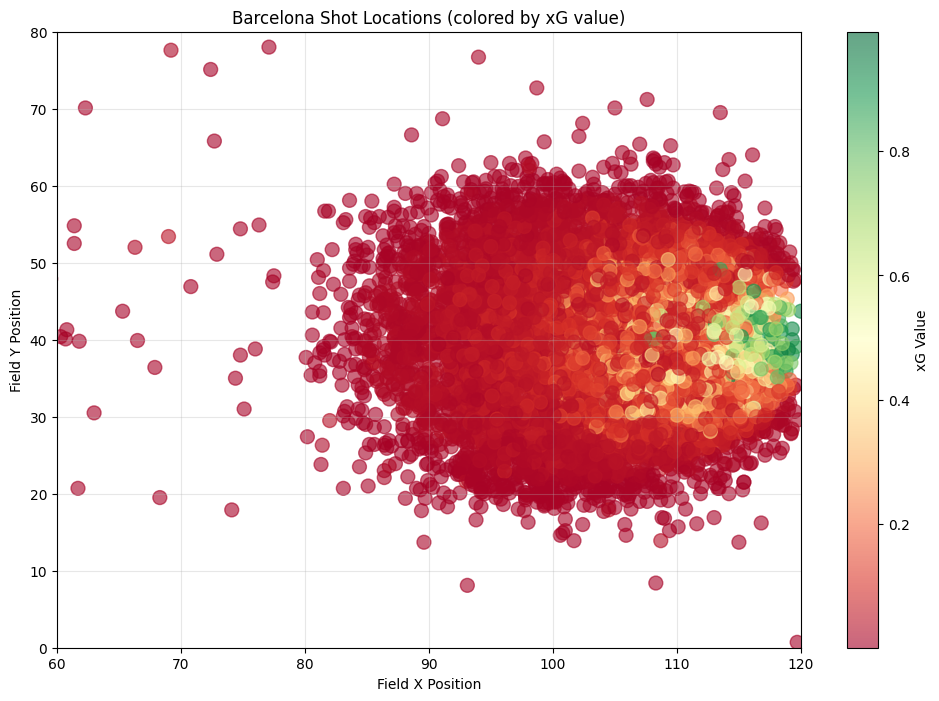

In [13]:
# Analyze where teams take shots from
import numpy as np

# Filter to one team for example
team_name = 'Barcelona'
team_shots = shot_quality[shot_quality['team'] == team_name].copy()

plt.figure(figsize=(12, 8))
plt.scatter(team_shots['location_x'], 
           team_shots['location_y'],
           c=team_shots['shot_statsbomb_xg'],
           s=100,
           alpha=0.6,
           cmap='RdYlGn')
plt.colorbar(label='xG Value')
plt.xlabel('Field X Position')
plt.ylabel('Field Y Position')
plt.title(f'{team_name} Shot Locations (colored by xG value)')
plt.xlim(60, 120)  # Focus on attacking half
plt.ylim(0, 80)
plt.grid(True, alpha=0.3)
plt.show()

### xG Over/Under Performance 

Goals vs xG (Finishing Quality), teams above the line are clinical finishers (better than expected). Teams below are wasteful.

Top Finishers (goals > xG):
                         team           xG  goals  goals_minus_xG  finish_pct
28                  Barcelona  1069.078857   1369      299.921143  128.054165
213       Paris Saint-Germain   196.520462    235       38.479538  119.580423
17                Arsenal WFC   132.706146    170       37.293854  128.102582
229               Real Madrid   132.019547    165       32.980453  124.981493
4                     AS Roma    61.949055     83       21.050945  133.981060
137                 Hyderabad    32.371510     49       16.628490  151.367671
171       Manchester City WFC   137.810028    154       16.189972  111.748036
188                    Napoli    72.274193     88       15.725807  121.758537
30           Bayer Leverkusen   122.493973    137       14.506027  111.842238
45   Borussia Mönchengladbach    50.180763     64       13.819237  127.538913

Worst Finishers (goals < xG):
                           team         xG  goals  goals_minus_xG  finish_pct
46   

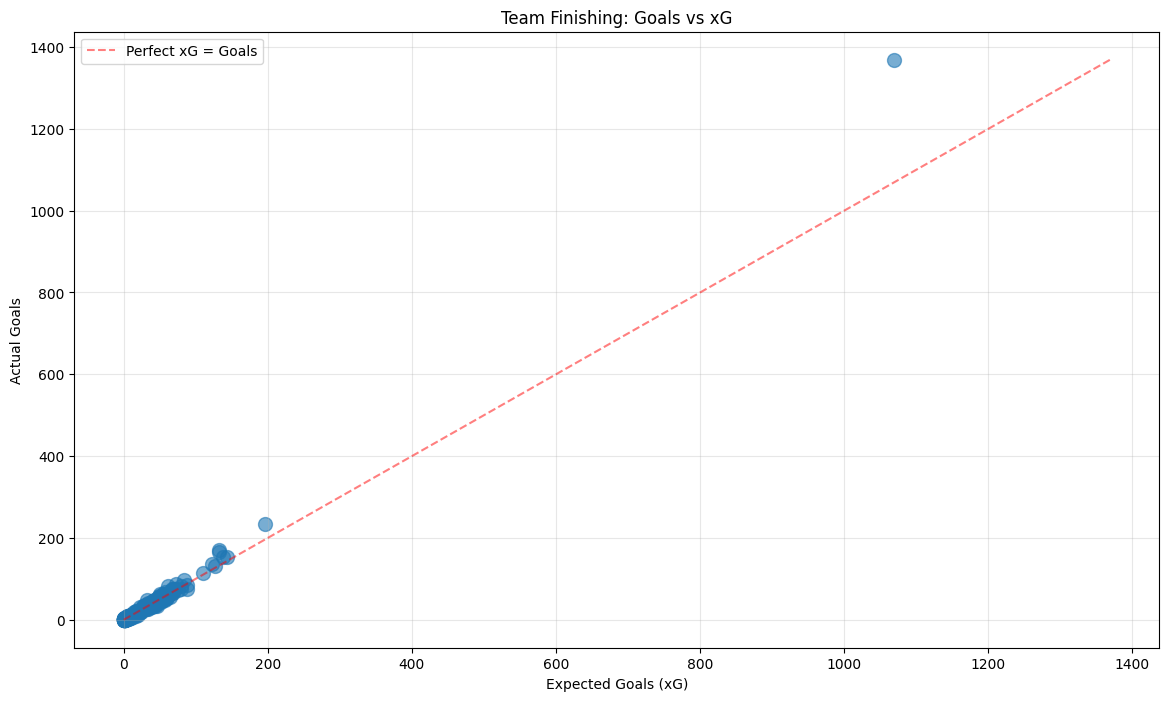

In [14]:
# Calculate actual goals scored vs expected goals
# Need to count actual goals from shot events

team_finishing = shot_quality.copy()
# Assuming shots have an outcome - adjust column name as needed
team_finishing['is_goal'] = team_finishing['shot_outcome'].apply(
    lambda x: 1 if x == 'Goal' else 0
) if 'shot_outcome' in team_finishing.columns else None

if team_finishing['is_goal'] is not None:
    finishing_stats = team_finishing.groupby('team').agg({
        'shot_statsbomb_xg': 'sum',  # Expected goals
        'is_goal': 'sum'              # Actual goals
    }).reset_index()
    
    finishing_stats.columns = ['team', 'xG', 'goals']
    finishing_stats['goals_minus_xG'] = finishing_stats['goals'] - finishing_stats['xG']
    finishing_stats['finish_pct'] = (finishing_stats['goals'] / finishing_stats['xG'] * 100)
    
    # Sort by overperformance
    finishing_stats = finishing_stats.sort_values('goals_minus_xG', ascending=False)
    
    print("Top Finishers (goals > xG):")
    print(finishing_stats.head(10))
    
    print("\nWorst Finishers (goals < xG):")
    print(finishing_stats.tail(10))
    
    # Visualize
    plt.figure(figsize=(14, 8))
    plt.scatter(finishing_stats['xG'], 
               finishing_stats['goals'],
               alpha=0.6, s=100)
    # Add diagonal line (perfect xG = goals)
    max_val = max(finishing_stats['xG'].max(), finishing_stats['goals'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect xG = Goals')
    plt.xlabel('Expected Goals (xG)')
    plt.ylabel('Actual Goals')
    plt.title('Team Finishing: Goals vs xG')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Defensive xG vs Goals Conceded (Goalkeeper Performance)

In [15]:
# Similar analysis for defense - are teams conceding more/less than expected?
# This may reveal goalkeeper quality

# Use existing team_match_xg dataset
# Need to add actual goals conceded

# Merge with match scores
defensive_performance = team_match_xg.merge(
    sb_matches[['match_id', 'home_team', 'away_team', 'home_score', 'away_score']],
    on='match_id',
    how='left'
)

# Calculate goals conceded for each team-match
defensive_performance['goals_conceded'] = defensive_performance.apply(
    lambda row: row['away_score'] if row['team'] == row['home_team'] 
                else row['home_score'],
    axis=1
)

# Aggregate by team
gk_performance = defensive_performance.groupby('team').agg({
    'xG_against': 'sum',        # Expected goals conceded
    'goals_conceded': 'sum'     # Actual goals conceded
}).reset_index()

gk_performance['goals_prevented'] = gk_performance['xG_against'] - gk_performance['goals_conceded']
gk_performance = gk_performance.sort_values('goals_prevented', ascending=False)

print("Best Goalkeeping (conceded < xG):")
print(gk_performance.head(10))

print("\nWorst Goalkeeping (conceded > xG):")
print(gk_performance.tail(10))

Best Goalkeeping (conceded < xG):
                    team  xG_against  goals_conceded  goals_prevented
253         South Africa   24.021042               3        21.021042
96       England Women's   35.605030              18        17.605030
95               England   37.162338              23        14.162338
213  Paris Saint-Germain   86.697495              73        13.697495
258                Spain   32.453087              19        13.453087
171  Manchester City WFC   54.014313              41        13.014313
107               France   40.441063              28        12.441063
74              Congo DR   17.369204               5        12.369204
268       Sweden Women's   31.312082              19        12.312082
108       France Women's   29.309483              18        11.309483

Worst Goalkeeping (conceded > xG):
                       team  xG_against  goals_conceded  goals_prevented
119                  Getafe   97.553001             118       -20.446999
298           

### Temporal Trends

xG Over Time (Season Progression)

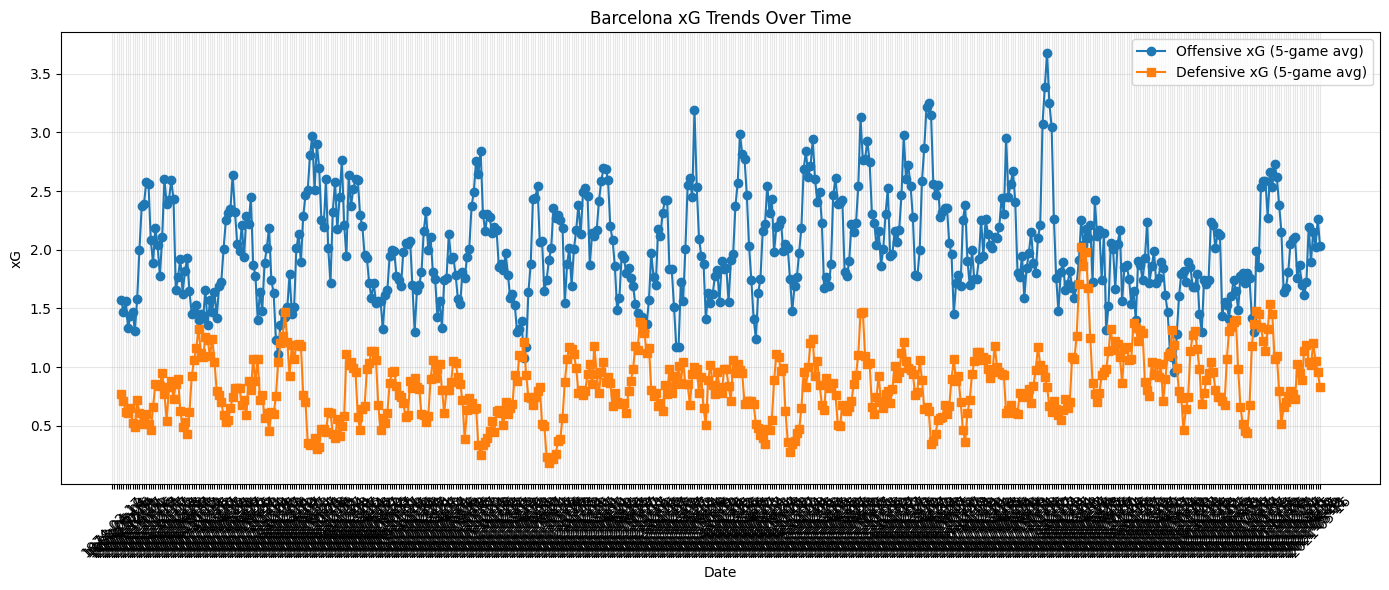

In [16]:
# How does team performance change over the season?
team_name = 'Barcelona'

team_timeline = team_match_xg[team_match_xg['team'] == team_name].copy()
team_timeline = team_timeline.sort_values('match_date')

# Add rolling averages
team_timeline['xG_for_rolling'] = team_timeline['xG_for'].rolling(window=5).mean()
team_timeline['xG_against_rolling'] = team_timeline['xG_against'].rolling(window=5).mean()

plt.figure(figsize=(14, 6))
plt.plot(team_timeline['match_date'], team_timeline['xG_for_rolling'], 
         label='Offensive xG (5-game avg)', marker='o')
plt.plot(team_timeline['match_date'], team_timeline['xG_against_rolling'], 
         label='Defensive xG (5-game avg)', marker='s')
plt.xlabel('Date')
plt.ylabel('xG')
plt.title(f'{team_name} xG Trends Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Home vs Away Performance

Teams with Best Home Defensive Advantage (lower xG at home):
location                   team      Away      Home  home_advantage
74                     Congo DR  3.227510  0.615827        2.611682
273            Thailand Women's  4.966917  2.733974        2.232943
26              Austria Women's  2.496570  0.306025        2.190545
101               FC Heidenheim  3.708372  1.819061        1.889311
51         CD Numancia de Soria  3.648033  1.773550        1.874483
61            Charlton Athletic  2.028119  0.323904        1.704215
118             Germany Women's  2.293784  0.731942        1.561842
286       United States Women's  1.625198  0.140959        1.484240
97            Equatorial Guinea  2.687251  1.220409        1.466842
108              France Women's  2.530167  1.086806        1.443361
204                    OL Reign  2.569057  1.190011        1.379046
76           Costa Rica Women's  3.316751  1.948386        1.368365
210              Panama Women's  3.555328  2.190797    

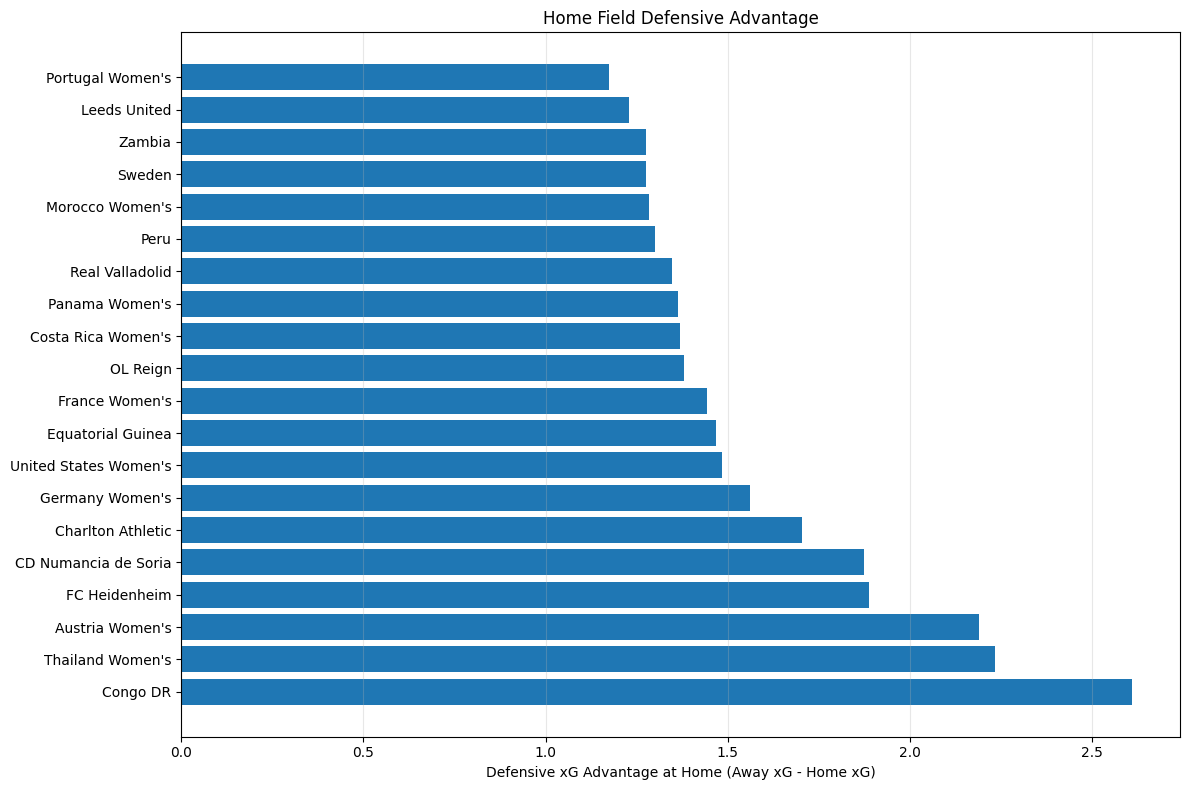

In [17]:
# Compare defensive performance at home vs away
home_away_stats = team_match_xg.groupby(['team', 'location']).agg({
    'xG_for': 'mean',
    'xG_against': 'mean',
    'match_id': 'count'
}).reset_index()

home_away_stats.columns = ['team', 'location', 'avg_xG_for', 'avg_xG_against', 'matches']

# Pivot for easier comparison
home_away_pivot = home_away_stats.pivot(
    index='team', 
    columns='location', 
    values='avg_xG_against'
).reset_index()

home_away_pivot['home_advantage'] = home_away_pivot['Away'] - home_away_pivot['Home']
home_away_pivot = home_away_pivot.sort_values('home_advantage', ascending=False)

print("Teams with Best Home Defensive Advantage (lower xG at home):")
print(home_away_pivot.head(15))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(20), home_away_pivot['home_advantage'].head(20))
plt.yticks(range(20), home_away_pivot['team'].head(20))
plt.xlabel('Defensive xG Advantage at Home (Away xG - Home xG)')
plt.title('Home Field Defensive Advantage')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Competition Comparison

Defensive Styles by League - Which leagues are more defensive? Which are more attacking?

Defensive Competition Comparison:
                competition  avg_xG_against  avg_xG_for  matches
6        FIFA U20 World Cup        1.086674    1.086674        2
4              Copa del Rey        1.087834    1.087834        6
18       UEFA Europa League        1.187603    1.187603        6
16                  Serie A        1.212865    1.212865      762
11                  Ligue 1        1.214207    1.214207      870
12      Major League Soccer        1.218263    1.218263       12
15           Premier League        1.271755    1.271755      836
8       Indian Super league        1.327137    1.327137      230
9                   La Liga        1.356784    1.356784     1736
0             1. Bundesliga        1.369426    1.369426      680
5   FA Women's Super League        1.417045    1.417045      650
20        Women's World Cup        1.469912    1.469912      230
17                UEFA Euro        1.484189    1.484189      204
10         Liga Profesional        1.529369    1.529369 

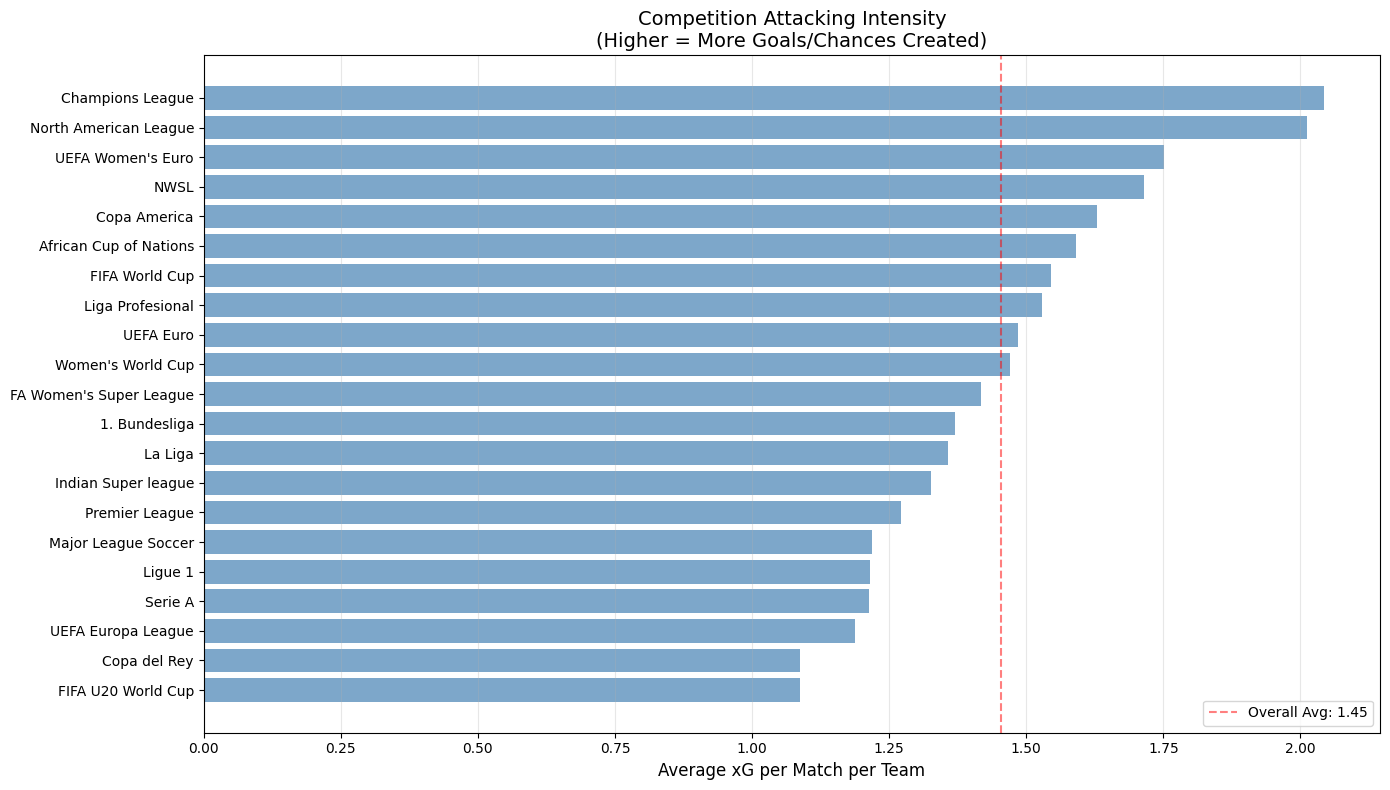

In [23]:
# Compare defensive metrics across competitions
league_stats = team_match_xg.groupby('competition_name').agg({
    'xG_against': 'mean',
    'xG_for': 'mean',
    'match_id': 'count'
}).reset_index()

league_stats.columns = ['competition', 'avg_xG_against', 'avg_xG_for', 'matches']
league_stats = league_stats.sort_values('avg_xG_against')

print("Defensive Competition Comparison:")
print(league_stats)

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))

# Since xG_for = xG_against, just use one
bars = ax.barh(range(len(league_stats)), league_stats['avg_xG_for'], color='steelblue', alpha=0.7)

ax.set_yticks(range(len(league_stats)))
ax.set_yticklabels(league_stats['competition'])
ax.set_xlabel('Average xG per Match per Team', fontsize=12)
ax.set_title('Competition Attacking Intensity\n(Higher = More Goals/Chances Created)', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Add a vertical line at overall average
avg_all = league_stats['avg_xG_for'].mean()
ax.axvline(avg_all, color='red', linestyle='--', alpha=0.5, label=f'Overall Avg: {avg_all:.2f}')
ax.legend()

plt.tight_layout()
plt.show()

### Matchup Analysis

xG in Derby/Rivalry Matches

In [24]:
# Analyze specific matchups
team1 = 'Barcelona'
team2 = 'Real Madrid'

rivalry_matches = team_match_xg[
    ((team_match_xg['team'] == team1) & (team_match_xg['opponent'] == team2)) |
    ((team_match_xg['team'] == team2) & (team_match_xg['opponent'] == team1))
].copy()

rivalry_matches = rivalry_matches.sort_values('match_date')

print(f"\n{team1} vs {team2} Matches:")
print(rivalry_matches[['match_date', 'team', 'opponent', 'xG_for', 'xG_against', 'location']])

# Average xG in these matches
print(f"\nAverage xG when {team1} plays {team2}:")
print(rivalry_matches.groupby('team')['xG_for'].mean())


Barcelona vs Real Madrid Matches:
      match_date         team     opponent    xG_for  xG_against location
2610  1974-02-17  Real Madrid    Barcelona  0.642152    2.439853     Home
6074  1974-02-17    Barcelona  Real Madrid  2.439853    0.642152     Away
2616  1983-06-04    Barcelona  Real Madrid  1.850840    1.198541     Home
6080  1983-06-04  Real Madrid    Barcelona  1.198541    1.850840     Away
324   2005-11-19  Real Madrid    Barcelona  0.390435    1.980959     Home
...          ...          ...          ...       ...         ...      ...
4191  2020-03-01    Barcelona  Real Madrid  1.069345    0.865274     Away
1305  2020-10-24    Barcelona  Real Madrid  1.248872    2.900068     Home
4769  2020-10-24  Real Madrid    Barcelona  2.900068    1.248872     Away
1298  2021-04-10  Real Madrid    Barcelona  1.321765    1.494464     Home
4762  2021-04-10    Barcelona  Real Madrid  1.494464    1.321765     Away

[62 rows x 6 columns]

Average xG when Barcelona plays Real Madrid:
team
Bar

Performance Against Top/Bottom Teams

In [25]:
# Classify teams as top/bottom based on overall xG differential
team_strength = team_defensive_stats.copy()
team_strength['net_xG'] = team_strength['avg_xG_for_per_match'] - team_strength['avg_xG_against_per_match']
team_strength = team_strength.sort_values('net_xG', ascending=False)

top_teams = team_strength.head(10)['team'].tolist()
bottom_teams = team_strength.tail(10)['team'].tolist()

# How do teams perform against strong vs weak opposition?
team_match_xg['opp_strength'] = team_match_xg['opponent'].apply(
    lambda x: 'Top' if x in top_teams else ('Bottom' if x in bottom_teams else 'Mid')
)

performance_vs_strength = team_match_xg.groupby(['team', 'opp_strength']).agg({
    'xG_for': 'mean',
    'xG_against': 'mean',
    'match_id': 'count'
}).reset_index()

print("Average Performance vs Top/Bottom Teams:")
print(performance_vs_strength[performance_vs_strength['team'] == 'Barcelona'])

Average Performance vs Top/Bottom Teams:
         team opp_strength    xG_for  xG_against  match_id
34  Barcelona       Bottom  3.116395    0.387547         5
35  Barcelona          Mid  1.999045    0.841500       527


### Defensive Consistency (Standard Deviation)

Low CV (coefficient of variation) = reliable defense. High CV = unpredictable.

In [26]:
# Which teams are most consistent defensively?
team_consistency = team_match_xg.groupby('team').agg({
    'xG_against': ['mean', 'std', 'count']
}).reset_index()

team_consistency.columns = ['team', 'avg_xG_against', 'std_xG_against', 'matches']
team_consistency['cv'] = team_consistency['std_xG_against'] / team_consistency['avg_xG_against']
team_consistency = team_consistency[team_consistency['matches'] >= 10]
team_consistency = team_consistency.sort_values('cv')

print("Most Consistent Defenses (low std deviation):")
print(team_consistency.head(15))

print("\nLeast Consistent Defenses (high variance):")
print(team_consistency.tail(15))

Most Consistent Defenses (low std deviation):
                       team  avg_xG_against  std_xG_against  matches        cv
87         Deportivo Alavés        2.543490        0.864920       11  0.340052
10                  Almería        2.289567        0.782715       11  0.341862
205                  Odisha        1.635654        0.594995       20  0.363766
305         Yeovil Town LFC        2.573647        0.976494       19  0.379420
94                   Empoli        1.175762        0.486182       38  0.413503
208                 Palermo        1.499541        0.639505       38  0.426467
84             Darmstadt 98        1.557205        0.681525       36  0.437659
124                 Granada        1.606166        0.708250       50  0.440957
169                Mallorca        1.953084        0.874399       12  0.447702
199        NorthEast United        1.883123        0.853048       20  0.452996
130             Hannover 96        1.812056        0.827397       34  0.456607
300   

### Win Probability Based on xG

Win % by xG Differential:
result        Away Win       Draw   Home Win
xG_diff_bin                                 
< -2         89.873418   5.696203   4.430380
-2 to -1     74.111675  17.258883   8.629442
-1 to 0      43.348624  30.733945  25.917431
0 to 1       20.629047  28.862165  50.508788
1 to 2        9.178744  17.391304  73.429952
> 2           2.424242   9.696970  87.878788


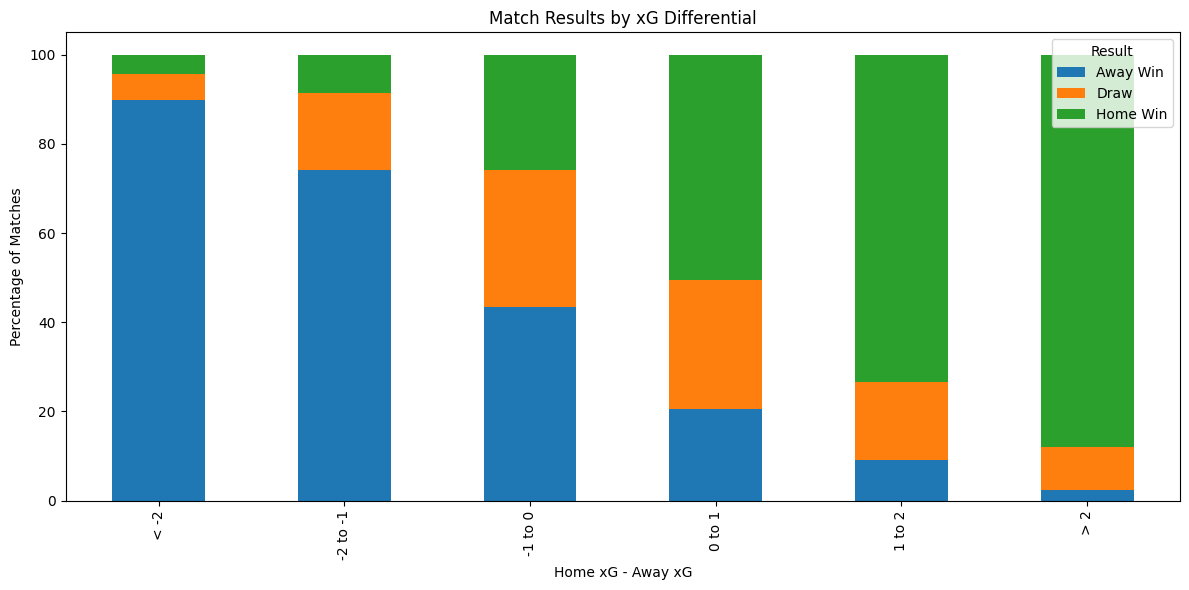

In [27]:
# Does higher xG differential predict wins?
match_xg_full['xG_diff'] = match_xg_full['home_xG'] - match_xg_full['away_xG']

# Get actual results
match_xg_full = match_xg_full.merge(
    sb_matches[['match_id', 'home_score', 'away_score']],
    on='match_id',
    how='left'
)

match_xg_full['result'] = match_xg_full.apply(
    lambda row: 'Home Win' if row['home_score'] > row['away_score']
                else ('Away Win' if row['away_score'] > row['home_score']
                else 'Draw'),
    axis=1
)

# Group by xG differential ranges
match_xg_full['xG_diff_bin'] = pd.cut(
    match_xg_full['xG_diff'], 
    bins=[-5, -2, -1, 0, 1, 2, 5],
    labels=['< -2', '-2 to -1', '-1 to 0', '0 to 1', '1 to 2', '> 2']
)

result_by_xg = pd.crosstab(
    match_xg_full['xG_diff_bin'], 
    match_xg_full['result'], 
    normalize='index'
) * 100

print("Win % by xG Differential:")
print(result_by_xg)

# Visualize
result_by_xg.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Home xG - Away xG')
plt.ylabel('Percentage of Matches')
plt.title('Match Results by xG Differential')
plt.legend(title='Result')
plt.tight_layout()
plt.show()

### Top xG Contributors

In [28]:
# Which players generate most xG?
if 'player' in shot_quality.columns:
    player_xg = shot_quality.groupby('player').agg({
        'shot_statsbomb_xg': ['sum', 'count', 'mean']
    }).reset_index()
    
    player_xg.columns = ['player', 'total_xG', 'shots', 'avg_xG_per_shot']
    player_xg = player_xg[player_xg['shots'] >= 10]  # Min 10 shots
    player_xg = player_xg.sort_values('total_xG', ascending=False)
    
    print("Top xG Generators:")
    print(player_xg.head(20))

Top xG Generators:
                                   player    total_xG  shots  avg_xG_per_shot
3485       Lionel Andrés Messi Cuccittini  363.372833   2670         0.136095
3594             Luis Alberto Suárez Díaz  111.744621    638         0.175148
4380        Neymar da Silva Santos Junior   77.399040    466         0.166092
1106  Cristiano Ronaldo dos Santos Aveiro   59.089970    413         0.143075
5196                   Samuel Eto''o Fils   50.778843    304         0.167036
3336                 Kylian Mbappé Lottin   50.457336    306         0.164893
5629                        Thierry Henry   49.121635    367         0.133846
5840                     Vivianne Miedema   47.927689    309         0.155106
496                     Antoine Griezmann   45.928726    284         0.161721
4687      Pedro Eliezer Rodríguez Ledesma   43.224209    317         0.136354
2223                           Harry Kane   36.905720    224         0.164758
6061                   Zlatan Ibrahimović   3